In [ ]:
import random
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
from numpy import linalg as LA
import math

%matplotlib inline
import matplotlib.pyplot as plt

from typing import TypeVar, Generic, List, Tuple, Union, Literal
from abc import ABC, abstractmethod
T = TypeVar('T') # Дженерики

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import random

from sklearn.metrics import roc_curve, auc

# Подготовка

## Извлечение графа и компонент связности

In [ ]:
G = nx.Graph()

# Читаем граф
with open('/content/CollegeMsg.txt', 'r') as file:
#with open('/content/sx-mathoverflow.txt', 'r') as file:
#with open('/content/network0.csv', 'r') as file:
    for line in file:
        # Split the line into source, destination, and timestamp
        source, destination, timestamp = map(int, line.split())
        # Add an edge to the graph (including timestamp)
        G.add_edge(source, destination, timestamp = timestamp)

# Базовое инфо о графе
print(G)

# Список компонент связности
connected_components = list(nx.connected_components(G))

# Самая крупная
largest_component = max(connected_components, key=len)
  # Удаляем петли

# Создание подграфа
F = G.subgraph(largest_component).copy()

Graph with 1899 nodes and 13838 edges


## Метрики

### Общая информация

In [ ]:
def generalGraphInfo(graph: nx.Graph, subgraph: nx.Graph) -> Tuple[int, int, int, float]:
  graph_nodes_num = graph.number_of_nodes()
  subgraph_nodes_num = subgraph.number_of_nodes()
  graph_edges_num = graph.number_of_edges()
  subgraph_to_graph_ratio = subgraph_nodes_num/graph_nodes_num

  print('Число узлов: ', graph_nodes_num, '\nЧисло рёбер: ', graph_edges_num)
  print('Число компонент связности:', len(connected_components))
  print('Плотность: ', f'{nx.density(graph):.4f}')
  print('Доля вершин в максимальной по мощности компоненте слабой связности:', f'{subgraph_to_graph_ratio:.4f}')


  subgraph_node_degrees = [degree[1] for degree in subgraph.degree()]
  print(f'Минимальная степень узла: {np.min(subgraph_node_degrees)}',
        f'Максимальная степень узла: {np.max(subgraph_node_degrees)}',
        f'Средняя степень узла: {np.mean(subgraph_node_degrees): .4f}', sep='\n')

  rad = nx.radius(subgraph)
  diam = nx.diameter(subgraph)

  print(f'Радиус графа {rad}',
        f'Диаметр графа {diam}',  sep='\n')
  return (graph_nodes_num, subgraph_nodes_num, graph_edges_num, subgraph_to_graph_ratio)

### Средний кластерный коэфициент

In [ ]:
def avg_cluster_coef(graph: nx.Graph, nodes_num: int) -> float:
  # Средний кластерный коэфициент
  Cl = 0
  nodes = graph.nodes()
  for i in nodes:
    k_ = graph.degree[i]
    neighbors_ = list(graph.adj[i])
    subgr_ = nx.induced_subgraph(graph, neighbors_)
    L_ = nx.number_of_edges(subgr_)

    if k_ >=2:
      loc_cl = 2*L_/(k_ * (k_ - 1))
    else:
      loc_cl = 0
    Cl += 1/nodes_num*loc_cl
  print('Средний кластерный коэффициент: ', f'{Cl: .4f}')
  return Cl

### Коэфициент ассортативности Пирсона

In [ ]:
def pearson_coef(graph: nx.Graph, graph_nodes_num: int) -> float:

  A = np.array(nx.adjacency_matrix(graph).todense())
  k = np.array(graph.degree).transpose()
  k = k[1]
  R1 = 0
  R2 = 0
  R3 = 0
  for i in k:
    R1 = R1 + i
    R2 = R2 + i**2
    R3 = R3 + i**3

  Re = 0

  for i in range(graph_nodes_num):
    for j in range(graph_nodes_num):
      #print(i,' ', j)
      Re = Re + A[i][j]*k[i]*k[j]

  r = (Re - R2/R1*R2)/(R3 - R2/R1*R2)

  print('R1 = ', R1)
  print('R2 = ', R2)
  print('R3 = ', R3)
  print('Re = ', Re)
  print('Коэф. ассортативности r = ', f'{r: .4f}')
  return r


## Вычисление метрик

### **Снежный ком**

In [ ]:
N = 1000
P = G.subgraph(largest_component).copy()
B = nx.Graph()
loops = list(nx.selfloop_edges(P))  # петли
P.remove_edges_from(loops)
boule_de_neige = random.sample(list(P.nodes), 1)
B.add_nodes_from(boule_de_neige)
while B.number_of_nodes() < N:
  open_edges = list(P.edges(B.nodes()))
  new_edges = [item for item in open_edges if item not in B.edges()]
  for i in new_edges:
    B.add_node(i[1])
    B.add_edge(i[0],i[1])
    if B.number_of_nodes() >= N:
      break

Graph with 1000 nodes and 2605 edges


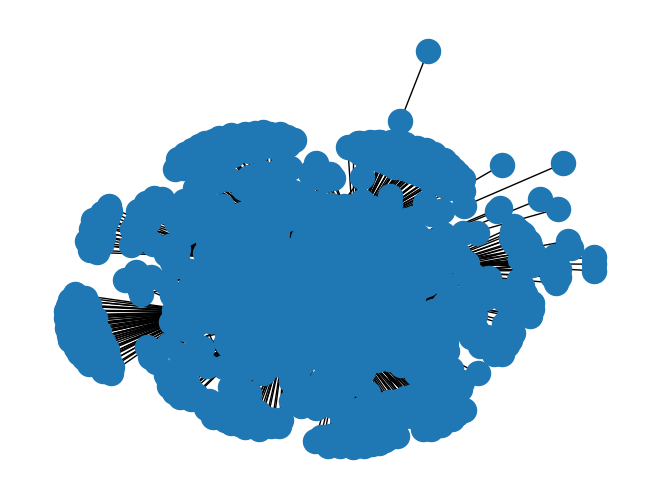

In [ ]:
print(B)
nx.draw(B)

In [ ]:
def is_subgraph(G, H):
    # Проверяем, что все вершины H есть в G
    if not all(node in G.nodes for node in H.nodes):
        return False

    # Проверяем, что все рёбра H есть в G
    if not all(edge in G.edges for edge in H.edges):
        return False

    return True

# Проверка
is_subgraph(P, B)

True

In [ ]:
[G_nodes_num, B_nodes_num, G_edges_num, B_to_G_ratio] = generalGraphInfo(G, B)

Cl = avg_cluster_coef(B, B_nodes_num)
PRS = pearson_coef(B, B_nodes_num)

NameError: name 'B' is not defined

### **Без снежного кома:**

In [ ]:
[G_nodes_num, F_nodes_num, G_edges_num, F_to_G_ratio] = generalGraphInfo(G, F)

Число узлов:  1899 
Число рёбер:  13838
Число компонент связности: 4
Плотность:  0.0077
Доля вершин в максимальной по мощности компоненте слабой связности: 0.9968
Минимальная степень узла: 1
Максимальная степень узла: 255
Средняя степень узла:  14.6170
Радиус графа 4
Диаметр графа 8


In [ ]:
# Средний кластерный коэфициент
Cl = avg_cluster_coef(F, F_nodes_num)

Средний кластерный коэффициент:   0.1097


In [ ]:
# Пирсон
PRS = pearson_coef(F, F_nodes_num)

R1 =  27670
R2 =  1539434
R3 =  173559424
Re =  69118102
Коэф. ассортативности r =  -0.1880


## Диапазон существования


In [ ]:
# Время существования графа
times = [data['timestamp'] for _, _, data in G.edges(data=True)]
time_max = max(times)
time_min = min(times)
print(time_max)
print(time_min)

time_percentile = np.percentile(times, 75)

print(f"70-й процентиль времени: {time_percentile}")

1098777142
1082040961
70-й процентиль времени: 1086493067.25


## Создание обучающей и тестовой выборок


In [ ]:
def generateSample(graph: nx.Graph, percentile)-> Tuple[nx.Graph, nx.Graph]:

  edu = nx.Graph()
  test = nx.Graph()
  # Копирование узлов
  edu.add_nodes_from(graph)
  test.add_nodes_from(graph)
  # отбрасывание узлов не входящих в 70-перцентиль
  for u, v, data in graph.edges(data=True):
    if data['timestamp'] <= percentile:
      edu.add_edge(u, v, timestamp=data['timestamp'])
    else:
      test.add_edge(u, v, timestamp=data['timestamp'])

  return (edu, test)

In [ ]:
[edu_F, test_F] = generateSample(F, time_percentile)

# Алгоритмы вычисления топологических признаков

## Метаданные вычислений

In [ ]:
class CalculationStrategy(ABC):
  '''
  Метаданные вычислений
  '''
  @abstractmethod
  def common_neighbors(*args, **kwargs) -> float:
    pass
  @abstractmethod
  def adamic_adar(*args, **kwargs) -> float:
    pass
  @abstractmethod
  def jaccard_coef(*args, **kwargs) -> float:
    pass
  @abstractmethod
  def preferential_attachment(*args, **kwargs) -> float:
    pass

  @abstractmethod
  def calculate_features(self, *args, **kwargs) -> Tuple[float, float, float, float]:
    pass


## Статические признаки

### Алгоритм вычисления

In [ ]:
class StaticStrategy(CalculationStrategy):

  def common_neighbors(self, nbhs1: set[T], nbhs2: set[T]) -> float:
    return len(nbhs1 & nbhs2)


  def adamic_adar(self, graph: nx.Graph, nbhs1: set[T], nbhs2: set[T]) -> float:
    CN: set[T] = nbhs1 & nbhs2

    _result: float = 0

    for nbh in CN:
      _result += math.log(len(list(graph.neighbors(nbh))))
    if _result:
      return 1/_result
    return 0


  def jaccard_coef(self, nbhs1: set[T], nbhs2: set[T]) -> float:
    if  len(nbhs1 | nbhs2):
      return len(nbhs1 & nbhs2)/len(nbhs1 | nbhs2)
    else:
      return 0


  def preferential_attachment(self, nbhs1: set[T], nbhs2: set[T]) -> float:
    return len(nbhs1) * len(nbhs2)



  def calculate_features(self, graph: nx.Graph, u: T, v: T, weightType = None) -> Tuple[float, float, float, float]:
    nbhs1: set[T] = set(graph.neighbors(u))
    nbhs2: set[T] = set(graph.neighbors(v))
    #print('ff')
    result = (
            self.common_neighbors(nbhs1, nbhs2),
            self.adamic_adar(graph, nbhs1, nbhs2),
            self.jaccard_coef(nbhs1, nbhs2),
            self.preferential_attachment(nbhs1, nbhs2)
    )
    return  result

### Класс для хранения признаков ребра

In [ ]:
class EdgeFeatures:
  def __init__(self, strategy: CalculationStrategy, CN: float = None, AA: float = None, JC: float = None, PA: float = None):
    self.strategy = strategy
    self.CN = CN
    self.AA = AA
    self.JC = JC
    self.PA = PA

  def updateValues(self, graph: nx.Graph, u: T, v: T, weightType = None):
    result = self.strategy.calculate_features(graph, u, v, weightType)
    [self.CN, self.AA, self.JC, self.PA] = result

  def getFeatures(self) -> Tuple[float, float, float, float]:
    return [self.CN, self.AA, self.JC, self.PA]


## Темпоральные признаки



### Вес + признаки + дополнительные метрики для мультиграфов

In [ ]:
class WeightedVec(EdgeFeatures):
  def __init__(self, weight: float, CN = None, AA = None, JC = None, PA = None, Q0: float = None, Q1: float = None, Q2: float = None, Q3: float = None, Q4: float = None, summarized: float = None, meaned: float = None, varianced: float = None):
    self.weight = weight
    self.strategy = TemporalStrategy()
    super().__init__(CN, AA, JC, PA, self.strategy)
    self.Q0 = Q0,
    self.Q1 = Q1,
    self.Q2 = Q2,
    self.Q3 = Q3,
    self.Q4 = Q4,
    self.summarized = summarized,
    self.meaned = meaned,
    self.varianced = varianced


### Вычисление весов

In [ ]:
def w_length(timestamp: int, time_min: int, time_max: int, l: float) -> float:
  return l + (1 - l) * (timestamp - time_min) / (time_max - time_min)

def w_exp(timestamp: int, time_min: int, time_max: int, l: float) -> float:
  return l + (1 - l) * math.e**(3*(timestamp - time_min) / (time_max - time_min) - 1) / (math.e**(3)-1)

def w_root(timestamp: int, time_min: int, time_max: int, l: float) -> float:
  return l + (1 - l) * math.sqrt((timestamp - time_min) / (time_max - time_min))



def calculate_weights(time: int, l) -> dict[str, WeightedVec]:
    weights = {
        'w_length': WeightedVec(w_length(time, time_min, time_max, l)),
        'w_exp' : WeightedVec(w_exp(time, time_min, time_max, l)),
        'w_root':  WeightedVec(w_root(time, time_min, time_max, l))
    }
    return weights

### Алгоритм вычисления

In [ ]:
class TemporalStrategy(CalculationStrategy):


  def common_neighbors(self, graph: nx.Graph, node_1: T, node_2: T, weightType: str) -> float:

    CN = set(graph.neighbors(node_1)) & set(graph.neighbors(node_2))
    result = 0

    for node_CN in CN:
      result += graph.get_edge_data(node_1, node_CN)[weightType].weight
      result += graph.get_edge_data(node_2, node_CN)[weightType].weight

    return result


  def adamic_adar(self, graph: nx.Graph, node_1: T, node_2: T, weightType: str) -> float:

    CN = set(graph.neighbors(node_1)) & set(graph.neighbors(node_2))

    result = 0

    for node_CN in CN:
      wtfu = graph.get_edge_data(node_1, node_CN)[weightType].weight
      wtfv = graph.get_edge_data(node_2, node_CN)[weightType].weight
      numenator = wtfv + wtfu

      node_CN_neighbors = graph.neighbors(node_CN)

      wtfz = 0
      for nbh_of_nbh in node_CN_neighbors:
        wtfz += graph.get_edge_data(node_CN, nbh_of_nbh)[weightType].weight
      denominator = math.log(1 + wtfz)

      result += numenator/denominator
    return result


  def jaccard_coef(self, graph: nx.Graph, node_1: T, node_2: T, weightType: str) -> float:
    CN = set(graph.neighbors(node_1)) & set(graph.neighbors(node_2))
    result = 0

    for node_CN in CN:
      numenator = 0
      denumenator = 0

      numenator += graph.get_edge_data(node_1, node_CN)[weightType].weight
      numenator += graph.get_edge_data(node_2, node_CN)[weightType].weight

      node_1_neighbors = graph.neighbors(node_1)
      node_2_neighbors = graph.neighbors(node_2)
      wtfx = 0
      wtfy = 0

      for n_1_nbh in node_1_neighbors:
        wtfx +=  graph.get_edge_data(node_1, n_1_nbh)[weightType].weight
      for n_2_nbh in node_2_neighbors:
        wtfy +=  graph.get_edge_data(node_2, n_2_nbh)[weightType].weight

      denumenator = wtfx + wtfy
      result += numenator/denumenator


    return result


  def preferential_attachment(self, graph: nx.Graph, node_1: T, node_2: T, weightType: str) -> float:
    wtfu = 0
    wtfv = 0


    for n_1_nbh in graph.neighbors(node_1):
      result = graph.get_edge_data(node_1, n_1_nbh)[weightType].weight
      wtfu += result

    for n_2_nbh in graph.neighbors(node_2):
      result = graph.get_edge_data(node_2, n_2_nbh)[weightType].weight
      wtfv += result

    return wtfu * wtfv


  def calculate_features(self, graph: nx.Graph, node_1: T, node_2: T, weightType: str) -> Tuple[float, float, float, float]:

          return (
              self.common_neighbors(graph, node_1, node_2, weightType),
              self.adamic_adar(graph, node_1, node_2, weightType),
              self.jaccard_coef(graph, node_1, node_2, weightType),
              self.preferential_attachment(graph, node_1, node_2, weightType)
          )

### Модель взвешенного ребра

In [ ]:
class WeightedEdge:
  def __init__(self, node1: T, node2: T, weight: float):
    self.node1 = node1
    self.node2 = node2
    self.weight = weight

# Обучение

## Обучение модели

In [ ]:
def learnModel(data_learn: List[Tuple[float, float, float, float]], labels_learn: List[Literal[0,1]], data_test: List[Tuple[float, float, float, float]], labels_test: List[Literal[0,1]], modType: str):
  # Преобразование в DataFrame
  df_train = pd.DataFrame(data_learn, columns=['CN_st','AA_st','JC_st','PA_st'])
  y_train = np.array(labels_learn)

  df_test = pd.DataFrame(data_test, columns=['CN_st','AA_st','JC_st','PA_st'])
  y_test = np.array(labels_test)
  # Разделение
  X_train = df_train  # Первые % для обучения
  X_test = df_test


  # Создание и обучение модели логистической регрессии
  model: LogisticRegression = LogisticRegression()
  model.fit(X_train, y_train)
  # Предсказание на тестовой выборке
  y_pred = model.predict(X_test)
  # Оценка модели
  accuracy = accuracy_score(y_test, y_pred)
  print(f'{modType} acc: {accuracy}')
  return (model, X_train, y_train, X_test, y_test, y_pred)

## Расчёт признаков, добавление данных в разметку

In [ ]:
def calculateMLData(graph: nx.Graph, u: T, v: T, strategy: CalculationStrategy, data: List[Tuple[float, float, float, float]], labels: List[Literal[0,1]], labelValue: Literal[0,1], weightType: str = None):
  edgeFts = EdgeFeatures(strategy)
  edgeFts.updateValues(graph, u, v, weightType)
  data.append(edgeFts.getFeatures())
  labels.append(labelValue)


## Обработка ребра

In [ ]:
def parseEdges(graph: nx.Graph, edges, strategy: CalculationStrategy, data: List[Tuple[float, float, float, float]], labels: List[Literal[0, 1]], N_store:dict[str, int], weightType: str = None) -> None:
  for u, v in edges:
    calculateMLData(graph, u, v, strategy, data, labels, 1, weightType)

  N_store['N'] = len(labels)



In [ ]:
def parseNonEdges(graph: nx.Graph, nonEdges, strategy: CalculationStrategy, data: List[Tuple[float, float, float, float]], labels: List[Literal[0, 1]], N_store: dict[str, int], weightType: str = None)-> None:
  i = 0
  for u, v in nonEdges:
    i += 1
    calculateMLData(graph, u, v, strategy, data, labels, 0, weightType)
    if i >= N_store['N']:
      break

## Разметка и обучение моделей

### Статическая

In [ ]:
def learnStaticModel(graph: nx.Graph, edu_graph: nx.Graph, test_graph: nx.Graph,
                     strategy: CalculationStrategy, non_edges: List,
                     test_non_edges: List, N_store: dict[str, int]):
  data_learn = []
  labels_learn = []
  data_test = []
  labels_test = []

  # обучающие данные
  parseEdges(edu_graph, edu_graph.edges(), strategy, data_learn, labels_learn, N_store)
  sliced_labels = labels_learn[N_store['N']:]
  parseNonEdges(edu_graph, edu_non_edges, strategy, data_learn, labels_learn, N_store)

  test_non_edges.extend(item for item in list(nx.non_edges(graph)) if item not in sliced_labels)

  # тестовые данные
  parseEdges(edu_graph, test_graph.edges(), strategy, data_test, labels_test, N_store)
  parseNonEdges(edu_graph, test_non_edges, strategy, data_test, labels_test, N_store)

  return learnModel(data_learn, labels_learn, data_test, labels_test, 'static')

### Темпоральная

In [ ]:
def learnTemporalModel(graph: nx.Graph, edu_graph: nx.Graph, test_graph: nx.Graph,
                       strategy: CalculationStrategy, edu_non_edges: List,
                       test_non_edges: List, N_store: dict[str, int],weightType: str):
  data_learn = []
  labels_learn = []
  data_test = []
  labels_test = []

  # обучающие данные
  parseEdges(edu_graph, edu_graph.edges(), strategy, data_learn, labels_learn, N_store, weightType)
  parseNonEdges(edu_graph, edu_non_edges, strategy, data_learn, labels_learn, N_store, weightType)

  # тестовые данные
  parseEdges(edu_graph, test_graph.edges(), strategy, data_test, labels_test, N_store, weightType)
  parseNonEdges(edu_graph, test_non_edges, strategy, data_test, labels_test, N_store, weightType)

  return learnModel(data_learn, labels_learn, data_test, labels_test, f'temporal {weightType}')

## Отрисовка графика

In [ ]:
def ROC_AUC(model: LogisticRegression, x_test, y_test, ft_type: str):
  y_scores = model.predict_proba(X_test)[:, 1]  # Вероятности положительного класса

  # ROC-кривая
  fpr, tpr, thresholds = roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)

  # Построение графика ROC-кривой
  plt.figure()
  plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='red', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic {ft_type}')
  plt.legend(loc='lower right')
  plt.grid()
  plt.savefig(f'AUC_{ft_type}')
  plt.show()

# Вычисления

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


static acc: 0.619866975130133


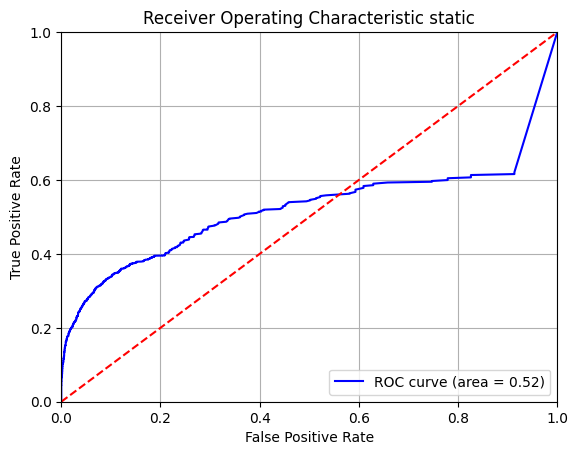

temporal w_length acc: 0.6299884326200116


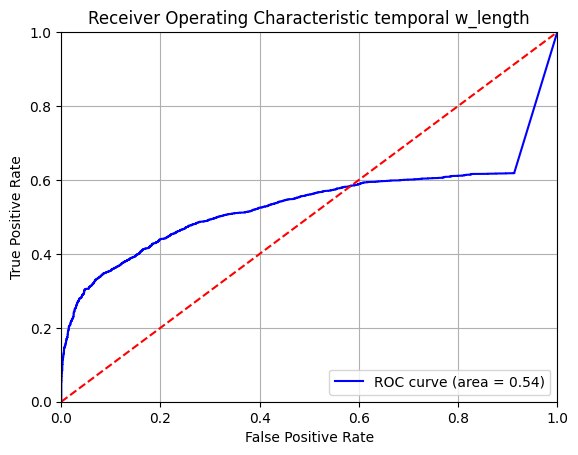

temporal w_exp acc: 0.6231925968768074


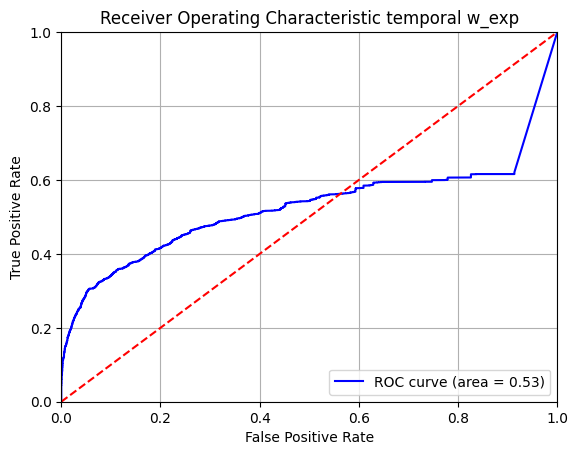

temporal w_root acc: 0.6281087333718912


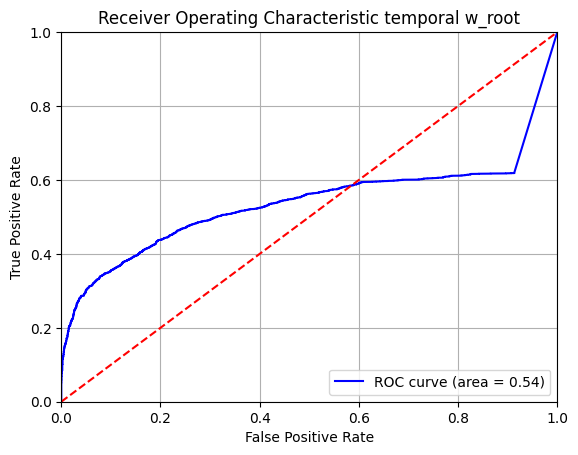

In [ ]:
temporalStrategy = TemporalStrategy()
staticStrategy = StaticStrategy()

l = 0.2

for edge in edu_F.edges:
  # Расчёт весов
  edu_F.add_edge(edge[0], edge[1], **calculate_weights(edu_F.get_edge_data(edge[0], edge[1])['timestamp'], l = 0.2))

N_store: dict[str, int] = {
  'N': None
}

edu_non_edges: List = list(nx.non_edges(edu_F))
random.shuffle(edu_non_edges) # Перемешивание списка
test_non_edges: List = []


(model, X_train, y_train, X_test, y_test, y_pred) = learnStaticModel(F, edu_F, test_F, staticStrategy, edu_non_edges, test_non_edges, N_store)
ROC_AUC(model, X_test, y_test, 'static')
(model, X_train, y_train, X_test, y_test, y_pred) = learnTemporalModel(F, edu_F, test_F, temporalStrategy, edu_non_edges, test_non_edges, N_store, 'w_length')
ROC_AUC(model, X_test, y_test, 'temporal w_length')
(model, X_train, y_train, X_test, y_test, y_pred) = learnTemporalModel(F, edu_F, test_F, temporalStrategy, edu_non_edges, test_non_edges, N_store, 'w_exp')
ROC_AUC(model, X_test, y_test, 'temporal w_exp')
(model, X_train, y_train, X_test, y_test, y_pred) = learnTemporalModel(F, edu_F, test_F, temporalStrategy, edu_non_edges, test_non_edges, N_store, 'w_root')
ROC_AUC(model, X_test, y_test, 'temporal w_root')